 <h1><center><b><td>Spam Detection</td></b></center></h1>

<h3><center><b><td><i>Classifying SMS messages as Spam or Legitimate</i></td></b></center></h3>

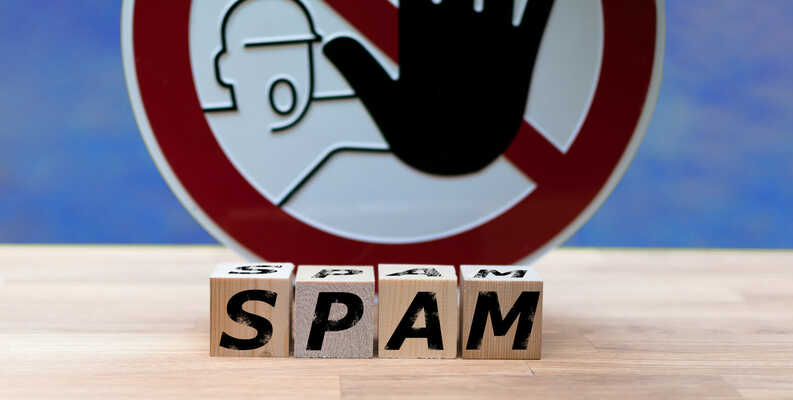

### Importing all necessary libraries 

In [1]:
# for data manipulation
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#for splitting the data
from sklearn.model_selection import train_test_split

# for data cleaning
import re
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

# for model training and predicting
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# for evaluating performance of models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# for crossvalidation
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VAISHALI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VAISHALI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Loading and reading the data

In [2]:
df = pd.read_csv(r"spam.csv", encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Shape of the dataset

In [3]:
shape = df.shape
print(f'There are {shape[0]} rows and {shape[1]} columns in the dataset')

There are 5572 rows and 5 columns in the dataset


### Columns of the dataset

In [4]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

### Basic information about the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
# All the columns are of object datatype

### Statistical summary 

In [7]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


<h1><center><b><td>Data Preprocessing</td></b></center></h1>

### Checking duplicates

In [8]:
df.duplicated().sum()

403

In [9]:
# There are 403 duplicate records in the dataset and it's better to remove them.

### Dropping duplicates

In [10]:
df = df.drop_duplicates()

### Checking missing values

In [11]:
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5126
Unnamed: 3    5159
Unnamed: 4    5164
dtype: int64

In [12]:
# Most of the values are missing in 3 columns : Unnamed: 2, Unnamed: 3, Unnamed: 4. Therefore, it's better to drop them.

### Handling missing values 

In [13]:
df.drop(columns = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1, inplace = True)

### Renaming columns

In [14]:
# for better understanding
df.rename(columns = {'v1':'Label', 'v2':'Messages'}, inplace = True)

In [15]:
df.head()

,Label,Messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<h1><center><b><td>Exploratory Data Analysis</td></b></center></h1>

### Unique values of Labels

In [16]:
df["Label"].value_counts()

ham     4516
spam     653
Name: Label, dtype: int64

In [17]:
## It's clearly an imbalanced dataset

### Count of spam and ham messages

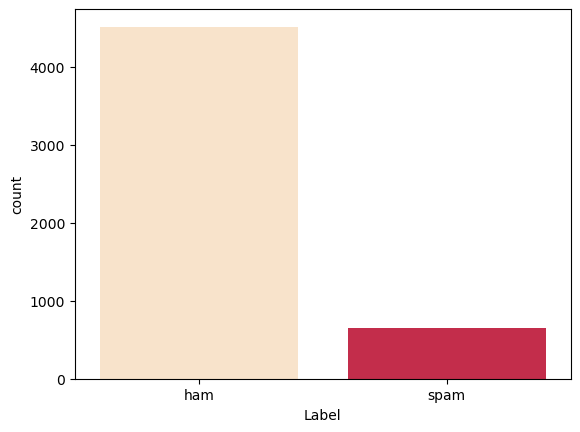

In [18]:
palette_color = [ "bisque", "crimson"]
sns.countplot(data = df, x = "Label", palette = palette_color)
plt.show()

In [19]:
# Number of spam messages are less in number than ham messages

### Proportion of ham and spam messages

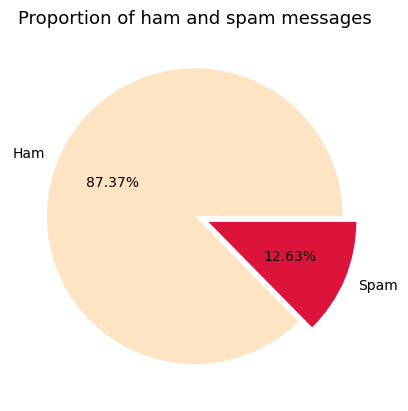

In [20]:
data = [df.Label.value_counts()[0], df.Label.value_counts()[1]]
palette_color = [ "bisque", "crimson"]
keys = ["Ham", "Spam"]
explode = [0, 0.1]
plt.pie(data, labels=keys, colors = palette_color, explode=explode, autopct='%.2f%%')
plt.title("Proportion of ham and spam messages", size = 13)
plt.show()

In [21]:
# Only 12.63% of the messages are spam.

### Checking length of messages

In [22]:
# counting the number of characters in a message
df['length']=df['Messages'].apply(len)

### Checking count of words and sentences in a message

In [23]:
# # counting the number of words in a message
df['words']=df['Messages'].apply(lambda x:len(nltk.word_tokenize(x)))

# counting the number of sentences in a message
df['sentences']=df['Messages'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [24]:
df.head()

,Label,Messages,length,words,sentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


### Description of ham messages

In [25]:
df[df['Label']=="ham"].describe()

,length,words,sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.120903,1.799601
std,56.358207,13.493725,1.278465
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


### Description of spam messages

In [26]:
df[df['Label']=="spam"].describe()

,length,words,sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


In [27]:
# Ham messages are much longer than spam messages.

### Visualizing distribution of length of messages

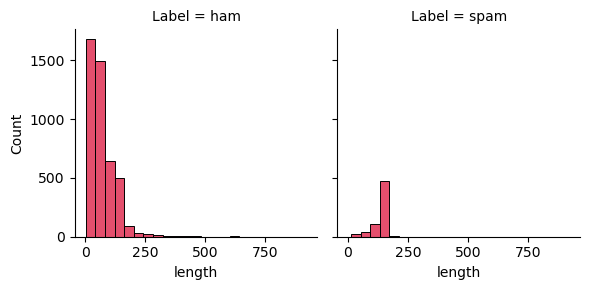

In [28]:
fg = sns.FacetGrid(df, col="Label")
fg.map(sns.histplot, "length", binwidth = 40, color = 'crimson')
plt.show()

### Visualizing distribution of words

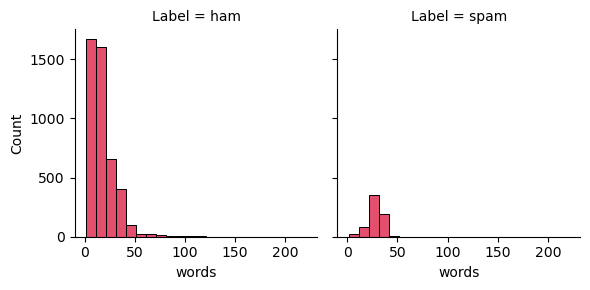

In [29]:
fg = sns.FacetGrid(df, col="Label")
fg.map(sns.histplot, "words", binwidth = 10, color = 'crimson')
plt.show()

### Visualizing distribution of sentences

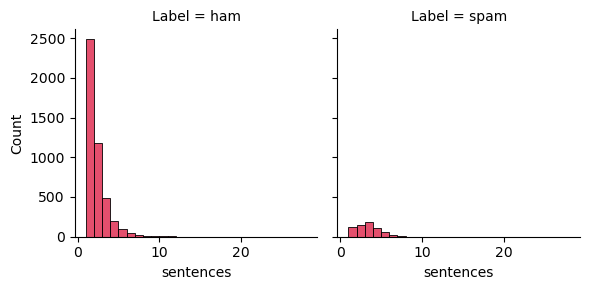

In [30]:
fg = sns.FacetGrid(df, col="Label")
fg.map(sns.histplot, "sentences", binwidth = 1, color = 'crimson')
plt.show()

### Converting categorical to numeric Labels

In [31]:
df["Label"] = df["Label"].replace("ham", 0)

In [32]:
df["Label"] = df["Label"].replace("spam", 1)

### Correlation among columns

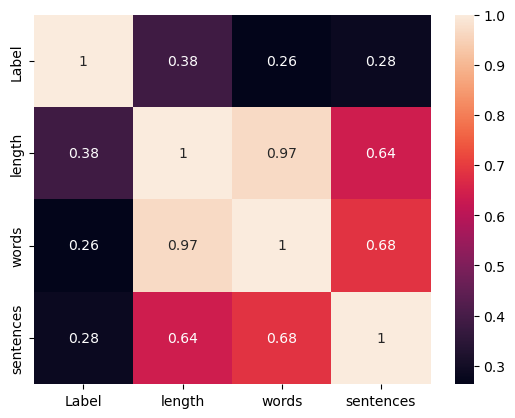

In [33]:
#plotting a heatmap for the correlation
sns.heatmap(df.corr(), annot=True)
plt.show()

As we can see the probelm of multicollinearity here, we cannot use all three columns instead we shall use only one and that should be "length" has it has highest correlation with Label, which is, 0.38. 

### Handling imbalanced dataset 

As we have already seen above that data is highly imbalanced. In this situation, the trained classifier often becomes biased towards the majority label class and tends to miss the minority class. This will be an issue in cases where we want to detect that minority class, for example, whether a message is spam or not (in current scenario). 
Therefore, it is important to handle such imbalanced dataset.

In [34]:
ham = df[df['Label'] == 0]
spam = df[df["Label"] == 1] 

In [35]:
spam = spam.sample(ham.shape[0], replace=True)

In [36]:
print(ham.shape, spam.shape)

(4516, 5) (4516, 5)


In [37]:
# dataset has become balanced now with equal number of spam and ham messages

### Shape of balanced dataset

In [38]:
data = ham.append(spam, ignore_index = True)
bal_shape = data.shape
print(f'Now there are {shape[0]} rows and {shape[1]} columns in the dataset')

Now there are 5572 rows and 5 columns in the dataset


### Dropping columns with high multicollinearity

In [39]:
data.drop(columns = ["words", "sentences"], axis = 1, inplace = True)

In [40]:
data.head()

,Label,Messages,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,0,U dun say so early hor... U c already then say...,49
3,0,"Nah I don't think he goes to usf, he lives aro...",61
4,0,Even my brother is not like to speak with me. ...,77


## Data Cleaning using NLTK (Natural Language Toolkit)

A powerful tool to preprocess text data for further analysis. It helps convert text into numbers, which the model can then easily work with.

### Text preprocessing

Derived Text data is usually unstructured and noisy. Text preprocessing involves transforming text into a clean and consistent format that can then be fed into a model for further analysis and learning. 
The various preprocessing steps that are involved are :

- Lower Casing : to ensure uniformity in the text.
- Tokenization : process of breaking up the paragraph into smaller units such as sentences or words to understand the meaning of text properly.
- Stop Word Removal : collection of words that occur frequently in any language but do not add much meaning to the sentences and it's better to remove them.
- Stemming & Lemmatization : to reduce a word into its root or stem word and lemmatizing to convert Each word into a meaningful parent word.

In [41]:
ps = PorterStemmer()
corpus = []

for i in range(0, len(data)):
    review = re.sub('[^a-zA-Z]', ' ', data["Messages"][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [42]:
# Length of processed messages
len(corpus)

9032

In [43]:
## Dataset after text preprocessing
data["Processed_messages"] = corpus
data.head()

,Label,Messages,length,Processed_messages
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,0,U dun say so early hor... U c already then say...,49,u dun say earli hor u c alreadi say
3,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think goe usf live around though
4,0,Even my brother is not like to speak with me. ...,77,even brother like speak treat like aid patent


## Visualizing words in messages

In [44]:
wc = WordCloud(width=800,
 height=400,
 min_font_size=2,
 #max_font_size=100,
 min_word_length=3,
 max_words=100, 
 background_color='white'
 )


### Words in ham messages

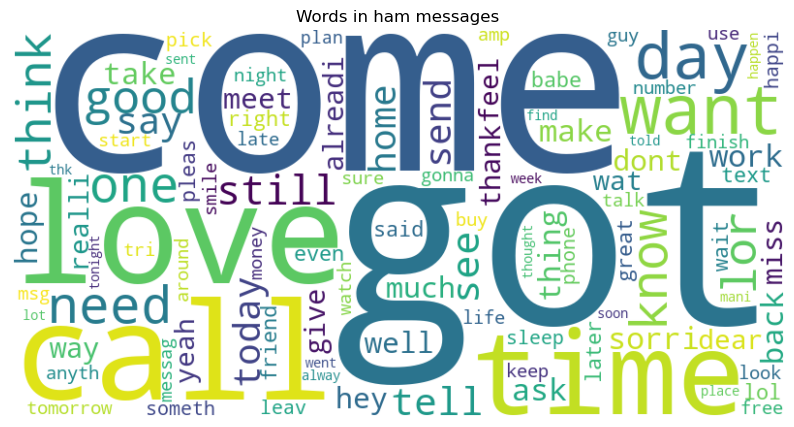

In [45]:
wc_ham = wc.generate(data[data['Label']==0]['Processed_messages'].str.cat(sep = " "))
plt.figure(figsize=(10, 6))
plt.imshow(wc_ham, interpolation='bilinear')
plt.axis('off')
plt.title('Words in ham messages')
plt.show()


### Words in spam messages

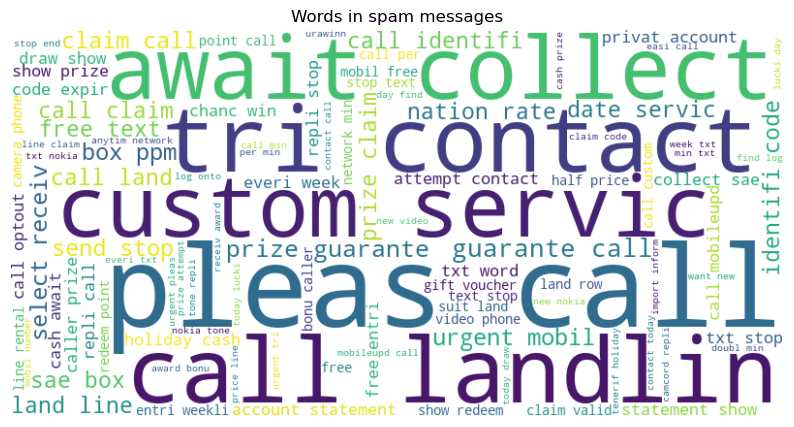

In [46]:
wc_spam = wc.generate(data[data['Label']==1]['Processed_messages'].str.cat(sep = " "))
plt.figure(figsize=(10, 6))
plt.imshow(wc_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Words in spam messages')
plt.show()

In [47]:
## The next step is to transform the text into meaningful representation of numbers using TF-IDF approach.

### TF-IDF Vectorizer

Term frequency Inverse document frequency (TFIDF) is a statistical formula to convert text documents into vectors based on the relevancy of the word. It is based on the bag of the words model to create a matrix containing the information about less relevant and most relevant words in the document.

In [48]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(corpus).toarray()
y = data['Label'].values

### Splitting data into training and test dataset

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

<h1><center><b><td>Model Building</td></b></center></h1>

## 1. Naive Bayes 

In [50]:
# fitting the model
nbmodel = MultinomialNB()
nbmodel.fit(X_train,y_train)

# predicting the output
y_pred = nbmodel.predict(X_test)
y_pred_train = nbmodel.predict(X_train)

In [51]:
# printing classification report

print('For test data')
print('-'*60)
print(classification_report(y_test, y_pred))
print('For train data')
print('-'*60)
print(classification_report(y_train, y_pred_train))

For test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       894
           1       0.98      0.97      0.98       913

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807

For train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3622
           1       0.98      0.98      0.98      3603

    accuracy                           0.98      7225
   macro avg       0.98      0.98      0.98      7225
weighted avg       0.98      0.98      0.98      7225



In [52]:
# printing accuracy, precision and recall score

print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred))

Accuracy score of Multinomial NB is:  0.9750968456004427
Precision score of the Multinomial NB is 0.9790286975717439
Recall score of the Multinomial NB is 0.9715224534501643


In [53]:
# printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[875  19]
 [ 26 887]]


##### Evaluating: ROC curve

In [54]:
# predict probabilities
y_pred_proba =nbmodel.predict_proba(X_test)

In [55]:
# creating an ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

# area under the curve
print(roc_auc)

0.9969420084241788


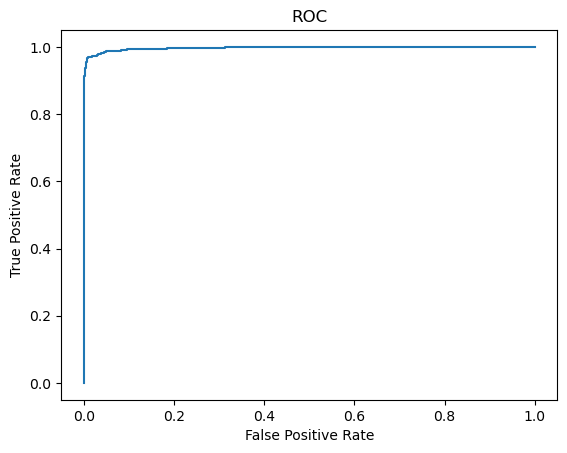

In [56]:
# plotting the ROC curve

%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

## 2. Logistic Regression

In [57]:
# training the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# predicting
y_pred = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

# results- Classification report
print('For test data')
print('-'*60)
print(classification_report(y_test,y_pred))
print('For train data')
print('-'*60)
print(classification_report(y_train,y_pred_train))

For test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       894
           1       0.99      0.98      0.99       913

    accuracy                           0.99      1807
   macro avg       0.99      0.99      0.99      1807
weighted avg       0.99      0.99      0.99      1807

For train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3622
           1       0.99      0.99      0.99      3603

    accuracy                           0.99      7225
   macro avg       0.99      0.99      0.99      7225
weighted avg       0.99      0.99      0.99      7225



In [58]:
# Confusion matrix
matrix = confusion_matrix(y_test,y_pred)
print(matrix)

[[884  10]
 [ 14 899]]


In [59]:
# printing accuracy, precision and recall score

print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred))

Accuracy score of Multinomial NB is:  0.9867183176535694
Precision score of the Multinomial NB is 0.988998899889989
Recall score of the Multinomial NB is 0.9846659364731654


In [60]:
# predict probabilities
y_pred_proba =logreg.predict_proba(X_test)

# creating an ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

# area under the curve
print (roc_auc)

0.9992489788317394


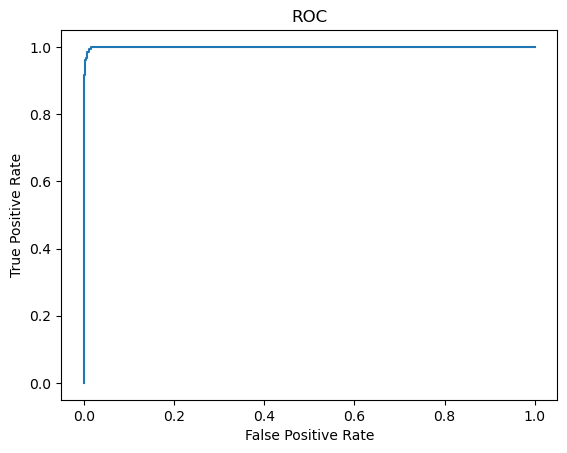

In [61]:
# plotting the ROC curve

%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

## 3.Decision Tree

In [62]:
# training the model
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

# predicting
y_predd = dt.predict(X_test)
y_predd_train=dt.predict(X_train)

# results - classifcation report
print('For test data')
print('-'*60)
print(classification_report(y_test,y_predd))
print('For train data')
print('-'*60)
print(classification_report(y_train,y_predd_train))


For test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       894
           1       0.96      1.00      0.98       913

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807

For train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3622
           1       1.00      1.00      1.00      3603

    accuracy                           1.00      7225
   macro avg       1.00      1.00      1.00      7225
weighted avg       1.00      1.00      1.00      7225



In [63]:
# Confusion matrix
matrix = confusion_matrix(y_test,y_predd)
print(matrix)

[[860  34]
 [  1 912]]


In [64]:
# printing accuracy, precision and recall score

print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred))

Accuracy score of Multinomial NB is:  0.9867183176535694
Precision score of the Multinomial NB is 0.988998899889989
Recall score of the Multinomial NB is 0.9846659364731654


In [65]:
# predict probabilities
y_pred_proba =dt.predict_proba(X_test)

# creating an ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

# area under the curve
print (roc_auc)

0.9804366949187843


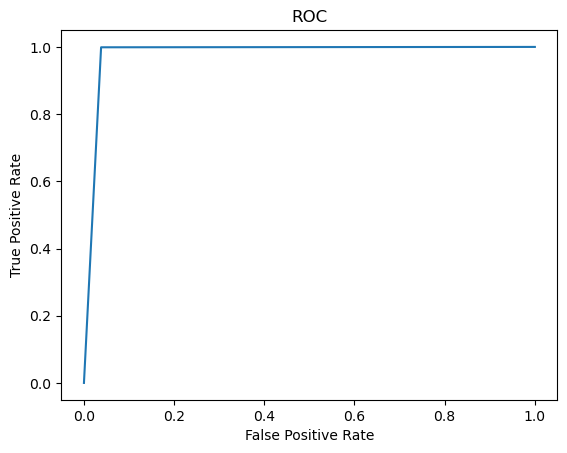

In [66]:
# plotting the ROC curve

%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

## 4. Random Forest

In [67]:
# training the model
rfc = RandomForestClassifier(max_depth = 6,random_state=77)
rfc.fit(X_train,y_train)

#predicting
y_pred = rfc.predict(X_test)
y_pred_train = rfc.predict(X_train)

# results- classification report
print('For test data')
print('-'*60)
print(classification_report(y_test,y_pred))
print('For train data')
print('-'*60)
print(classification_report(y_train,y_pred_train))

For test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       894
           1       0.99      0.84      0.91       913

    accuracy                           0.91      1807
   macro avg       0.92      0.92      0.91      1807
weighted avg       0.93      0.91      0.91      1807

For train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      3622
           1       1.00      0.84      0.91      3603

    accuracy                           0.92      7225
   macro avg       0.93      0.92      0.92      7225
weighted avg       0.93      0.92      0.92      7225



In [68]:
# Confusion matrix
matrix = confusion_matrix(y_test,y_pred)
print(matrix)

[[887   7]
 [147 766]]


In [69]:
# printing accuracy, precision and recall score

print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred))

Accuracy score of Multinomial NB is:  0.914775871610404
Precision score of the Multinomial NB is 0.9909443725743855
Recall score of the Multinomial NB is 0.8389923329682366


In [70]:
# predict probabilities
y_pred_proba =rfc.predict_proba(X_test)

# creating an ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

# area under the curve
print (roc_auc)

0.9876118261943441


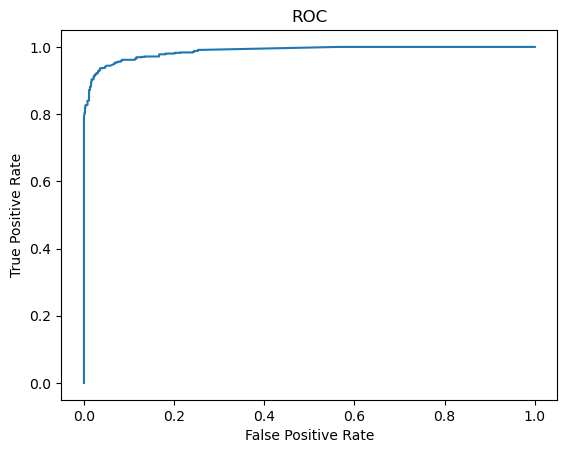

In [71]:
# plotting the ROC curve

%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

## 5. SVM

In [72]:
svc = SVC(probability=True, random_state=77)
svc.fit(X_train,y_train)

y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)


print('For test data')
print('-'*60)
print(classification_report(y_test,y_pred))
print('For train data')
print('-'*60)
print(classification_report(y_train,y_pred_train))

For test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       894
           1       1.00      1.00      1.00       913

    accuracy                           1.00      1807
   macro avg       1.00      1.00      1.00      1807
weighted avg       1.00      1.00      1.00      1807

For train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3622
           1       1.00      1.00      1.00      3603

    accuracy                           1.00      7225
   macro avg       1.00      1.00      1.00      7225
weighted avg       1.00      1.00      1.00      7225



In [73]:
# Confusion matrix
matrix = confusion_matrix(y_test,y_pred)
print(matrix)

[[894   0]
 [  0 913]]


In [74]:
# printing accuracy, precision and recall score

print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred))

Accuracy score of Multinomial NB is:  1.0
Precision score of the Multinomial NB is 1.0
Recall score of the Multinomial NB is 1.0


In [75]:
# predict probabilities
y_pred_proba =svc.predict_proba(X_test)

# creating an ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

# area under the curve
print (roc_auc)

1.0


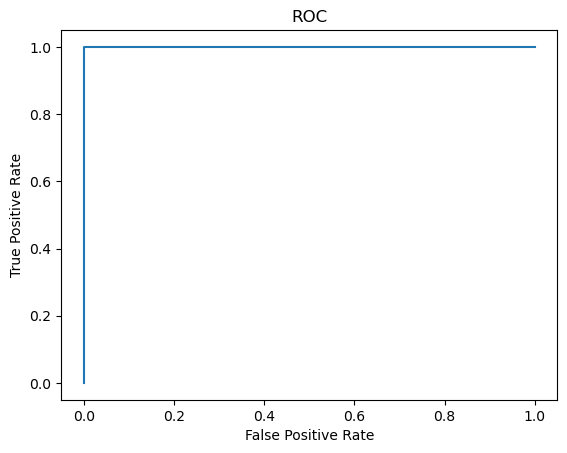

In [76]:
# plotting the ROC curve

%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

## 6. Gradient Boosting

In [77]:
gdb = GradientBoostingClassifier()
gdb.fit(X_train,y_train)

y_pred = gdb.predict(X_test)
y_pred_train = gdb.predict(X_train)


print('For test data')
print('-'*60)
print(classification_report(y_test,y_pred))
print('For train data')
print('-'*60)
print(classification_report(y_train,y_pred_train))

For test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       894
           1       0.96      0.95      0.95       913

    accuracy                           0.95      1807
   macro avg       0.95      0.95      0.95      1807
weighted avg       0.95      0.95      0.95      1807

For train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3622
           1       0.96      0.95      0.95      3603

    accuracy                           0.95      7225
   macro avg       0.95      0.95      0.95      7225
weighted avg       0.95      0.95      0.95      7225



In [78]:
# Confusion matrix
matrix = confusion_matrix(y_test,y_pred)
print(matrix)

[[859  35]
 [ 49 864]]


In [79]:
# printing accuracy, precision and recall score

print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred))

Accuracy score of Multinomial NB is:  0.9535141117874931
Precision score of the Multinomial NB is 0.9610678531701891
Recall score of the Multinomial NB is 0.9463307776560789


In [80]:
# predict probabilities
y_pred_proba =gdb.predict_proba(X_test)

# creating an ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

# area under the curve
print (roc_auc)

0.9920615959873663


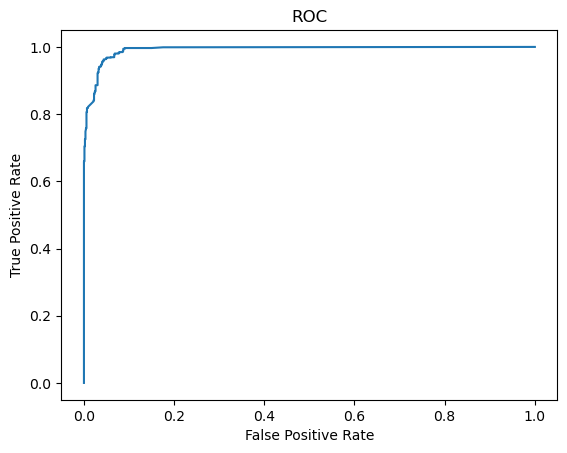

In [81]:
# plotting the ROC curve

%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

## XG Boost

In [82]:
xgb= XGBClassifier()
xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)


print('For test data')
print('-'*60)
print(classification_report(y_test,y_pred))
print('For train data')
print('-'*60)
print(classification_report(y_train,y_pred_train))


For test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       894
           1       0.99      1.00      0.99       913

    accuracy                           0.99      1807
   macro avg       0.99      0.99      0.99      1807
weighted avg       0.99      0.99      0.99      1807

For train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3622
           1       1.00      1.00      1.00      3603

    accuracy                           1.00      7225
   macro avg       1.00      1.00      1.00      7225
weighted avg       1.00      1.00      1.00      7225



In [83]:
# Confusion matrix
matrix = confusion_matrix(y_test,y_pred)
print(matrix)

[[883  11]
 [  1 912]]


In [84]:
# printing accuracy, precision and recall score

print('Accuracy score of Multinomial NB is: ',accuracy_score(y_test,y_pred))
print('Precision score of the Multinomial NB is',precision_score(y_test,y_pred))
print('Recall score of the Multinomial NB is',recall_score(y_test,y_pred))

Accuracy score of Multinomial NB is:  0.9933591588267847
Precision score of the Multinomial NB is 0.9880823401950163
Recall score of the Multinomial NB is 0.9989047097480832


In [85]:
# predict probabilities
y_pred_proba =xgb.predict_proba(X_test)

# creating an ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

# area under the curve
print (roc_auc)

0.9992005851349265


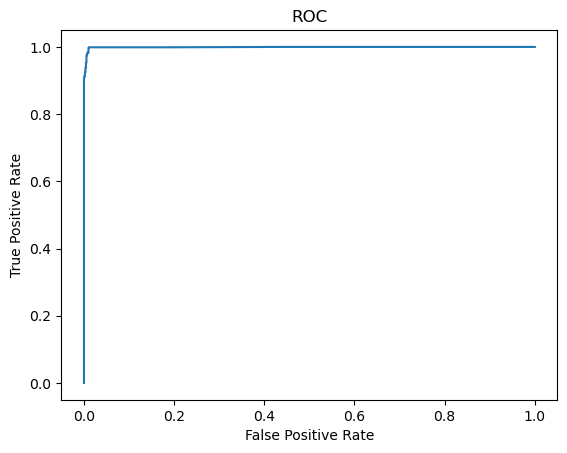

In [86]:
# plotting the ROC curve

%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)
plt.show()

<h1><center><b><td>Cross Validation</td></b></center></h1>

In [87]:
# Function to find out mean of cross-validation scores

def cv(model):
    acc_scores = cross_val_score(model, X_train, y_train, cv=10)
    Mean_accuracy_score = acc_scores.mean()
    
    prec_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="precision")
    Mean_precision_score = prec_scores.mean()
    
    rec_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="recall")
    Mean_recall_score = rec_scores.mean()
    
    f1_scores = cross_val_score(model, X_train, y_train, cv=10, scoring="f1")
    Mean_f1_score = f1_scores.mean()
    
    return (round(Mean_accuracy_score, 3)), (round(Mean_precision_score,3)), (round(Mean_recall_score,3)), (round(Mean_f1_score,3))

##### 1. Naive Bayes

In [88]:
nb = MultinomialNB().fit(X_train, y_train)
nb_accuracy, nb_precision, nb_recall, nb_f1 = cv(nb)
nb_results = {'Accuracy Score':nb_accuracy, 'Presion_Score':nb_precision, 'Recall_score':nb_recall, 'f1_Score':nb_f1}
print(nb_results)

{'Accuracy Score': 0.972, 'Presion_Score': 0.97, 'Recall_score': 0.974, 'f1_Score': 0.972}


##### 2. Logistic Regression

In [89]:
logreg = LogisticRegression(random_state = 11).fit(X_train, y_train)
lr_accuracy, lr_precision, lr_recall, lr_f1 = cv(logreg)
lr_results = {'Accuracy Score':lr_accuracy, 'Presion_Score':lr_precision, 'Recall_score':lr_recall, 'f1_Score':lr_f1}
print(lr_results)

{'Accuracy Score': 0.984, 'Presion_Score': 0.987, 'Recall_score': 0.981, 'f1_Score': 0.984}


##### 3. Decision Tree

In [90]:
dt = DecisionTreeClassifier(random_state = 11).fit(X_train, y_train)
dt_accuracy, dt_precision, dt_recall, dt_f1 = cv(dt)
dt_results = {'Accuracy Score':dt_accuracy, 'Presion_Score':dt_precision, 'Recall_score':dt_recall, 'f1_Score':dt_f1}
print(dt_results)

{'Accuracy Score': 0.974, 'Presion_Score': 0.951, 'Recall_score': 0.999, 'f1_Score': 0.974}


##### 4. Random Forest

In [91]:
rfc = RandomForestClassifier().fit(X_train, y_train)
rfc_accuracy, rfc_precision, rfc_recall, rfc_f1 = cv(rfc)
rfc_results = {'Accuracy Score':rfc_accuracy, 'Presion_Score':rfc_precision, 'Recall_score':rfc_recall, 'f1_Score':rfc_f1}
print(rfc_results)

{'Accuracy Score': 0.998, 'Presion_Score': 0.997, 'Recall_score': 0.999, 'f1_Score': 0.998}


##### 5. SVM 

In [92]:
svc = SVC().fit(X_train, y_train)
svc_accuracy, svc_precision, svc_recall, svc_f1 = cv(svc)
svc_results = {'Accuracy Score':svc_accuracy, 'Presion_Score':svc_precision, 'Recall_score':svc_recall, 'f1_Score':svc_f1}
print(svc_results)

{'Accuracy Score': 0.998, 'Presion_Score': 0.997, 'Recall_score': 0.999, 'f1_Score': 0.998}


##### 6. Gradient Boosting

In [93]:
gdb = GradientBoostingClassifier().fit(X_train, y_train)
gdb_accuracy, gdb_precision, gdb_recall, gdb_f1 = cv(gdb)
gdb_results = {'Accuracy Score':gdb_accuracy, 'Presion_Score':gdb_precision, 'Recall_score':gdb_recall, 'f1_Score':gdb_f1}
print(gdb_results)

{'Accuracy Score': 0.949, 'Presion_Score': 0.958, 'Recall_score': 0.939, 'f1_Score': 0.948}


##### XG Boost

In [94]:
xgb = XGBClassifier().fit(X_train, y_train)
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1 = cv(xgb)
xgb_results = {'Accuracy Score':xgb_accuracy, 'Presion_Score':xgb_precision, 'Recall_score':xgb_recall, 'f1_Score':xgb_f1}
print(xgb_results)

{'Accuracy Score': 0.988, 'Presion_Score': 0.984, 'Recall_score': 0.992, 'f1_Score': 0.988}


<h1><center><b><td>Performance Evaluation</td></b></center></h1>

In [95]:
data = [['Naive Bayes', nb_accuracy, nb_precision, nb_recall, nb_f1],
       ['Logistic Regression', lr_accuracy, lr_precision, lr_recall, lr_f1], 
       ['Decision Tree', dt_accuracy, dt_precision, dt_recall, dt_f1],
       ['Random Forest', rfc_accuracy, rfc_precision, rfc_recall, rfc_f1],
       ['SVM', svc_accuracy, svc_precision, svc_recall, svc_f1],
       ['Gradient boosting', gdb_accuracy, gdb_precision, gdb_recall, gdb_f1],
       ['XG Boost', xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]]

model_performance = pd.DataFrame(data, columns=["Models", "Accuracy", "Precision", "Recall", "f1"])

In [96]:
#define function for values greater than 98%
def cond_formatting(x):
    if x > 0.985:
        return 'background-color: orange'
    else:
        return None

#define function for highlighting max values
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

#display DataFrame with conditional formatting applied    

model_performance.style.\
    applymap(cond_formatting, subset = ["Accuracy", "Precision", "Recall", "f1"]).\
    apply(highlight_max, subset = ["Accuracy", "Precision", "Recall", "f1"])

,Models,Accuracy,Precision,Recall,f1
0,Naive Bayes,0.972000,0.970000,0.974000,0.972000
1,Logistic Regression,0.984000,0.987000,0.981000,0.984000
2,Decision Tree,0.974000,0.951000,0.999000,0.974000
3,Random Forest,0.998000,0.997000,0.999000,0.998000
4,SVM,0.998000,0.997000,0.999000,0.998000
5,Gradient boosting,0.949000,0.958000,0.939000,0.948000
6,XG Boost,0.988000,0.984000,0.992000,0.988000


**Cells highlighted with:**

- orange color shows the values greater than 98.5% and
- yellow color shows the max values.

**Best-Performing Models:**

SVM and Random Forest

**Both the models have performed equally well and predicted correct labels with the 99.8% accuracy**